In [2]:
import pandas as pd

In [3]:
pd.__version__

'2.1.1'

In [4]:
#! pip install pyarrow

In [5]:
df_jan = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet', engine='pyarrow')

In [6]:
df_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet', engine='pyarrow')

In [7]:
df_jan.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.0,0.5,0.0,0.0,1.0,14.3,2.5,0.0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.0,0.5,4.0,0.0,1.0,16.9,2.5,0.0


In [7]:
df_feb.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-02-01 00:04:45,2024-02-01 00:19:58,1.0,4.39,1.0,N,68,236,1,20.5,1.0,0.5,1.28,0.0,1.0,26.78,2.5,0.0
1,2,2024-02-01 00:56:31,2024-02-01 01:10:53,1.0,7.71,1.0,N,48,243,1,31.0,1.0,0.5,9.00,0.0,1.0,45.00,2.5,0.0


In [8]:
assert (df_jan.columns == df_feb.columns).all(), "Not same schema"

In [8]:
df_jan.shape

(3066766, 19)

In [9]:
df_feb.shape

(2913955, 19)

### Q1 Read the data for January. How many columns are there?

#### Answer Q1 : 19  colums

### Q2 Computing duration : What's the standard deviation of the trips duration in January?



In [10]:
# duration in minutes : dropoff - pickup

df_jan["duration"] = (df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime).dt.total_seconds() / 60

In [11]:
df_jan.duration

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3066766, dtype: float64

In [12]:
df_jan.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

#### Answer for Q2 : 42.59 

### Q3. Dropping outliers : What fraction of the records left after you dropped the outliers?

In [13]:
import numpy as np 
df_jan["outlier"] = np.logical_or(df_jan.duration <1, df_jan.duration >60)


In [14]:
df_jan.outlier.value_counts(normalize=True) * 100

outlier
False    98.122028
True      1.877972
Name: proportion, dtype: float64

#### Answer Q3 : Around 98% of the original dataset.

In [15]:
# removing outlier
df_jan = df_jan[~df_jan.outlier].reset_index(drop=True)
# dropping outlier column
df_jan = df_jan.drop(columns=["outlier"])

In [16]:
df_jan.shape

(3009173, 20)

### Q4: One hot encoding

In [17]:
categorical_features = ['PULocationID','DOLocationID']
target_column = ["duration"] 
used_columns = categorical_features + target_column


df_jan_used = df_jan[used_columns].copy()

In [18]:
df_jan_used.head()

,PULocationID,DOLocationID,duration
0,161,141,8.433333
1,43,237,6.316667
2,48,238,12.750000
3,138,7,9.616667
4,107,79,10.833333


In [19]:
df_jan_used[categorical_features] = df_jan_used[categorical_features].astype(str)

In [20]:
df_jan_used.dtypes

PULocationID     object
DOLocationID     object
duration        float64
dtype: object

In [21]:

features_dict = df_jan_used[categorical_features].to_dict(orient='records')

In [22]:
features_dict[:2]

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'}]

In [23]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer()
vectorized_features = dv.fit_transform(features_dict)


In [25]:
# df_encoded = pd.get_dummies(data=df_jan_used, prefix_sep="_", dtype=float)

In [28]:
print(len(dv.feature_names_))

515


#### Answer Q4 : Here we get 515 features

## Modeling

In [30]:
X_train = vectorized_features

In [31]:
y_train = df_jan_used[target_column].values.reshape(-1)
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

#### Feature engineering pipeline

In [92]:


class DurationDataProcessor:

    def compute_duration(self, X):
        try:
            X_transformed = X.copy()
            X_transformed["duration"] = X_transformed["tpep_dropoff_datetime"] - X_transformed["tpep_pickup_datetime"]
            X_transformed["duration"] = X_transformed["duration"].dt.total_seconds() / 60
            return X_transformed
        except Exception as e:
            return f"The following error occured: {e}."

    def remove_outlier(self, X, test_column, lower_bound=1, upper_bound=60, y=None):
        X_transformed = X.copy()
        try:
            X_transformed = X_transformed[(X_transformed[test_column]>= lower_bound) & (X_transformed[test_column] <= upper_bound)]
            return X_transformed
        except Exception as e:
            return f"The following error occured: {e}."
    
    def get_records(self, X, used_features:list[str], target_column: str):
        try:
            X_transformed = X.copy()
            if not target_column in X_transformed.columns:
                X_transformed = self.compute_duration(X_transformed)
                target_column = "duration"
            used_columns = used_features + [target_column]
            X_transformed = X_transformed[used_columns].copy()
            # remove outlier
            X_transformed = self.remove_outlier(X=X_transformed, test_column=target_column)
            y = X_transformed[target_column].copy().values
            X_transformed_features = X_transformed[used_features].astype(str)
            X_transformed_dict = X_transformed_features.to_dict(orient='records')
            return X_transformed_dict, y
        
        except Exception as e:
            return f"The following error occured: {e}."

    def extract_features_target(self, X, used_features:list[str], target_column: str, y=None):
        try:
            dv = DictVectorizer()
            X_transformed = X.copy()
            
            X_transformed_dict, y = self.get_records(X_transformed, used_features=used_features, target_column=target_column)
            X_transformed_vectorized = dv.fit_transform(X_transformed_dict)
            del X_transformed, X_transformed_dict
            return X_transformed_vectorized, y, dv
        
        except Exception as e:
            return f"The following error occured: {e}."

Processor = DurationDataProcessor()

In [73]:
X_train, y_train, dv_train= Processor.extract_features_target(X=df_jan, used_features=categorical_features, target_column="duration")

In [74]:
len(dv_train.feature_names_)

515

In [75]:
from sklearn.linear_model import LinearRegression

In [76]:
lr = LinearRegression()

In [77]:
lr.fit(X_train, y_train)

LinearRegression()

In [78]:
y_train_pred = lr.predict(X_train)

In [79]:
y_train_pred

array([11.52725252, 10.89771098, 11.32563992, ..., 11.73750143,
       12.70533063, 11.54268673])

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/2m/ys1b248x6l93pxxf85kdct740000gn/T/ipykernel_950/3566353440.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_pred, label="prediction")
/var/folders/2m/ys1b248x6l93pxxf85kdct740000gn/T/ipykernel_950/3566353440.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, l

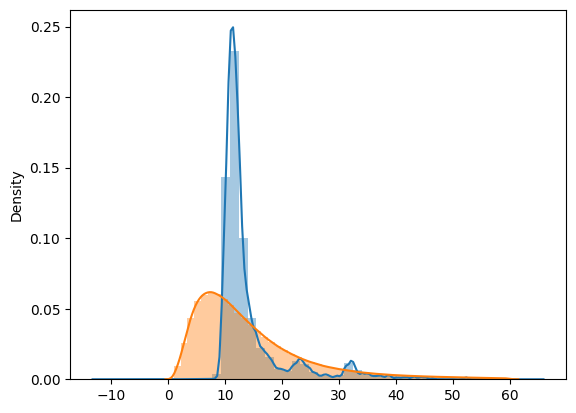

In [81]:
sns.distplot(y_train_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error

In [83]:
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print(f"MSE on train : {mse_train}")
print(f"RMSE on train : {rmse_train}")

MSE on train : 58.511208038349004
RMSE on train : 7.649261927686161


#### Answer Q5:  RMSE is 7.64

### Q6 Evaluating the model

In [84]:
X_feb, y_feb = Processor.get_records(X=df_feb, used_features=categorical_features, target_column="duration")

In [89]:
y_test = y_feb
X_test = dv_train.transform(X_feb)

In [90]:
assert X_train.shape[1] == X_test.shape[1], "Not same number of features"

In [91]:
y_test_pred = lr.predict(X_test)


mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print(f"MSE on test : {mse_test}")
print(f"RMSE on test : {rmse_test}")

MSE on test : 61.02449980150599
RMSE on test : 7.811817957524739


### Answer to Q6 : RMSE is 7.81 on validation set